## Analysis of scraped data form KV.ee

### Imports of packages

In [1]:
import os # this is needed atleast for me because otherwise reprojection of coordinate systems does not work. 
os.environ['PROJ_DATA'] = r'C:\Users\Dan\micromamba\envs\geopython2025\Library\share\proj'
os.environ['PROJ_LIB'] = r'C:\Users\\Dan\micromamba\envs\geopython\Library\share\proj'

In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from tqdm import tqdm
import numpy as np
import matplotlib.patches as mpatches

In [74]:
import mapclassify
import matplotlib.colors as mcolors
from mapclassify import NaturalBreaks
import contextily as ctx
from networkx import ego_graph
from shapely.geometry import box
from itertools import chain
import seaborn as sns
import matplotlib

### Data setup

In [4]:
tqdm.pandas()

In [5]:
# Tartu only for now
df = pd.read_csv("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_csvs/listings_cleaned_tartu.csv", sep=";") 
gdf_rent = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf_rent = gdf_rent.to_crs(epsg=3301) # reprojecting the data into the Estonian national coordinate system. So from a geographic coordinate system to a projected coordinate system


In [95]:
#gdf_rent

#### OSM roads download

In [7]:
# Defining the study area
place_name = "Tartu, Estonia"
gdf_place = ox.geocode_to_gdf(place_name) # queries OpenStreetMap service to find the geographical boundary polygon of Tartu city not including the rural areas such as former Tähtvere municipality
polygon = gdf_place.geometry.iloc[0] # extracts the polygon

In [8]:
# Downloading the streetnetwork form OpenStreetMap
G = ox.graph_from_polygon(polygon, network_type='walk') # downloads the street network that is inside the polygon
G = ox.project_graph(G, to_crs='EPSG:3301')  # reprojecting the data into the Estonian national coordinate system 

#### OSM services download

In [ ]:
# Getting all the tags that are classified as amenities form OpenStreetmaps data that are inside the study area
tags_amenity = {"amenity": True}
amenity = ox.features_from_polygon(polygon, tags_amenity)
amenity = amenity.to_crs(gdf_rent.crs)

In [ ]:
# Since some of these POI geometries are points and some are polygons we will split them for cleaning
amenity_points = amenity[amenity.geometry.type == "Point"]
amenity_polygons = amenity[amenity.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [ ]:
# Turning polygon geometries into centroids
amenity_polygons_centroids = amenity_polygons.copy()
amenity_polygons_centroids["geometry"] = amenity_polygons_centroids.geometry.centroid

In [ ]:
# Combining the data that were points and the data that were polygons but were turned into points
amenity_combined = pd.concat([amenity_points, amenity_polygons_centroids])
amenity_combined = amenity_combined.reset_index(drop=True)

In [ ]:
# Getting all the tags that are classified as shops and leisure form OpenStreetmaps data that are inside the study area
tags_shop = {"shop": True}
tags_leisure = {"leisure": True}
shops = ox.features_from_polygon(polygon, tags_shop)
leisure = ox.features_from_polygon(polygon, tags_leisure)
# Matching the CRS (coordinate referece system)
shops = shops.to_crs(gdf_rent.crs)
leisure = leisure.to_crs(gdf_rent.crs)

In [ ]:
# Shops
shops_points = shops[shops.geometry.type == "Point"]
shops_polygons = shops[shops.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Leisure
leisure_points = leisure[leisure.geometry.type == "Point"]
leisure_polygons = leisure[leisure.geometry.type.isin(["Polygon", "MultiPolygon"])]

In [ ]:
# Shops
shops_polygons_centroids = shops_polygons.copy()
shops_polygons_centroids["geometry"] = shops_polygons_centroids.geometry.centroid

# Leisure
leisure_polygons_centroids = leisure_polygons.copy()
leisure_polygons_centroids["geometry"] = leisure_polygons_centroids.geometry.centroid

In [ ]:
# Shops
shops_combined = pd.concat([shops_points, shops_polygons_centroids]).reset_index(drop=True)

# Leisure
leisure_combined = pd.concat([leisure_points, leisure_polygons_centroids]).reset_index(drop=True)

#### Looking at the data

In [ ]:
# Get nodes and edges from the graph as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# Create a base plot
fig, ax = plt.subplots(figsize=(10, 10))

# Optional: plot rental listings too
gdf_rent.plot(ax=ax, markersize=15, color='blue', alpha=0.6, label="Rent Listings")

# Plot the edges (streets)
edges.plot(ax=ax, linewidth=0.8, color='gray', label="Streets")

# Plot the nodes (intersections)
#nodes.plot(ax=ax, markersize=5, color='black', label="Nodes")

# Plot amenities (POIs)
#amenity_combined.plot(ax=ax, markersize=20, color='red', alpha=0.6, label="Amenities")



# Add legend and title
ax.set_title("Tartu: Street Network, Amenities, and Rental Listings", fontsize=14)
ax.legend()

plt.show()

#### hide

In [ ]:
pd.set_option("display.max_rows", None)
print(amenity_combined["amenity"].value_counts())

In [ ]:
for col in amenity_combined.columns:
    print(col)

In [ ]:
amenity_combined.info()

In [ ]:
# checking types
pd.set_option("display.max_rows", None)
print(shops_combined["shop"].value_counts())  # Top shop types
print(leisure_combined["leisure"].value_counts())  # Top leisure types



In [ ]:
pd.reset_option("display.max_rows")

In [ ]:
# Checking column names
print(list(shops_combined.columns))


In [ ]:
print(list(leisure_combined.columns))

## Osm data cleaning

#### Cleaning amenities data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio = amenity_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep = non_missing_ratio[non_missing_ratio >= 0.2].index
amenity_reduced = amenity_combined[cols_keep]
print(list(amenity_reduced.columns))

In [ ]:
amenity_cleaned = amenity_reduced.drop(columns=["backrest"]) # removing backrest aswell because that is not useful at all

In [ ]:
amenity_cleaned[["geometry", "amenity"]].isna().sum() # check for missing values.

In [ ]:
# amenities that are likely to influence rent prices
important_amenities = [
    # education
    "school", "university", "college", "kindergarten", "childcare", "training", "language_school",
    # health
    "pharmacy", "hospital", "clinic", "doctors", "dentist", 
    # admin
    "atm", "bank", "post_office", "courthouse", "townhall",
    # transport
    "parking", "parking_space", "bicycle_parking",
    "charging_station", "fuel", "taxi", "bus_station",
    # leisure
    "restaurant", "cafe", "bar", "pub", "fast_food", "cinema", "theatre",
    "arts_centre", "concert_hall", "nightclub",
    # public
    "community_centre", "social_facility", "library", "marketplace", "public_building",
    "coworking_space", "events_venue",
    # safety
    "police", "fire_station",
    # utilities
    "post_box", "parcel_locker", "recycling", "waste_disposal", "drinking_water"
]

In [ ]:
amenity_clean = amenity_cleaned[amenity_cleaned["amenity"].isin(important_amenities)].reset_index(drop=True)


In [ ]:
pd.set_option("display.max_rows", None)
print(amenity_clean["amenity"].value_counts())

In [ ]:
pd.reset_option("display.max_rows")

#### Cleaning shops data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_shops = shops_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_shops = non_missing_ratio_shops[non_missing_ratio_shops >= 0.2].index
shops_reduced = shops_combined[cols_keep_shops].copy()
print(list(shops_reduced.columns))

In [ ]:
shops_reduced[['geometry', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'name', 'opening_hours', 'operator', 'phone', 'shop', 'website', 'wheelchair', 'addr:country', 'check_date', 'level']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

In [ ]:
shops_clean = shops_reduced.drop(columns=['addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'name', 'opening_hours', 'operator', 'phone', 'website', 'wheelchair', 'addr:country', 'check_date', 'level']) 
# removing other data. doesn't seem useful

In [ ]:
shops_clean

In [ ]:
weird_shops = ["yes", "no", "vacant"]  # basically NaN values
shops_clean = shops_clean[~shops_clean["shop"].isin(weird_shops)]

In [ ]:
shop_counts = shops_clean["shop"].value_counts()

# Keeping shop types that appear at least 3 times
shops_clean = shops_clean[shops_clean["shop"].isin(shop_counts[shop_counts >= 3].index)]

In [ ]:
pd.set_option("display.max_rows", None)
print(shops_clean["shop"].value_counts()) 

In [ ]:
pd.reset_option("display.max_rows")

#### Cleaning leisure data

In [ ]:
# Calculating the proportion of nonmissing values per column
non_missing_ratio_leisure = leisure_combined.notna().mean()

# Keeping only columns with at least 20% data
cols_keep_leisure = non_missing_ratio_leisure[non_missing_ratio_leisure >= 0.2].index
leisure_reduced = leisure_combined[cols_keep_leisure].copy()
print(list(leisure_reduced.columns))

In [ ]:
leisure_reduced[['geometry', 'access', 'leisure', 'sport', 'garden:type']].isna().sum() # check for missing values.
# looking to see if these fields could be valuable

In [ ]:
leisure_clean = leisure_reduced.drop(columns=[ 'access', 'sport', 'garden:type']) # removing other data. doesn't seem useful

In [ ]:
pd.set_option("display.max_rows", None)
print(leisure_clean["leisure"].value_counts()) 

In [ ]:
pd.reset_option("display.max_rows")

In [ ]:
# this data requires no further cleaning 

## Osm data aggregation

#### Aggregating amenities data

In [ ]:
# making a dictionary for amenity groups
amenity_categories = {
    "education": ["school", "kindergarten", "childcare", "training", "language_school"],
    
    "higher_education": ["university", "college"],
    
    "healthcare": ["pharmacy", "clinic", "hospital", "doctors", "dentist"],
    
    "finance_admin": ["atm", "bank", "courthouse", "post_office", "townhall"],
    
    "transport": ["bus_station", "taxi", "fuel", "charging_station", "police", "fire_station", "bicycle_rental"],
    
    "parking": ["parking", "parking_space", "bicycle_parking"],
    
    "food_drink": ["restaurant", "cafe", "fast_food", "bar", "pub", "marketplace"],

    "community_social": ["community_centre", "social_facility", "library", "coworking_space","public_building", "events_venue", "arts_centre", "theatre", "concert_hall", "nightclub", "cinema"],
    
    "services_utilities": ["recycling", "waste_disposal", "drinking_water", "post_box", "parcel_locker"]}

In [ ]:
amenity_to_category = {
    amenity: category
    for category, amenities in amenity_categories.items()
    for amenity in amenities
}

In [ ]:
# Function to map an amenity to its group
amenity_clean["category"] = amenity_clean["amenity"].map(amenity_to_category)


In [ ]:
amenity_clean

In [ ]:
print(amenity_clean["category"].value_counts(dropna=False))

#### Aggregating shops data

In [ ]:
shop_categories = {
    "clothing": ["clothes", "shoes", "jewelry", "bag", "tailor", "second_hand"],
    "food_grocery": ["supermarket", "bakery", "butcher", "greengrocer", "convenience", "alcohol"],
    "health_beauty": ["hairdresser", "beauty", "optician", "medical_supply", "e-cigarette"],
    "home_furniture": ["furniture", "appliance", "doityourself", "hardware", "bed"],
    "electronics": ["electronics", "computer", "communication"],
    "sports_leisure": ["sports", "toys", "fishing"],
    "vehicles": ["car", "car_repair", "car_parts", "bicycle", "tyres"],
    "misc_services": ["kiosk", "locksmith", "dry_cleaning", "copyshop", "gift", "trade", "stationery", "craft", "baby_goods", "erotic", "general", "mall", "florist"],
    "other": ["books", "tobacco", "pet"]
}

In [ ]:
shop_to_category = {
    shop: category
    for category, shops in shop_categories.items()
    for shop in shops
}

In [ ]:
shops_clean["category"] = shops_clean["shop"].map(shop_to_category)

In [ ]:
print(shops_clean["category"].value_counts(dropna=False))


#### Aggregating leisure data

In [ ]:
leisure_categories = {
    "parks_green": ["garden", "park", "nature_reserve", "dog_park"],
    "sports_facilities": ["pitch", "sports_centre", "fitness_station", "fitness_centre", "track", "stadium", "sports_hall", "bowling_alley", "trampoline_park", "horse_riding", "ice_rink", "swimming_pool","disc_golf_course","swimming_area"],
    "play_recreation": ["playground", "indoor_play", "picnic_table", "bleachers", "outdoor_seating", "village_swing", "firepit", "sauna", "marina", "slipway"],
    "other": ["hackerspace", "tanning_salon"]
}

In [ ]:
leisure_to_category = {
    leisure: category
    for category, leisures in leisure_categories.items()
    for leisure in leisures
}

In [ ]:
leisure_clean["category"] = leisure_clean["leisure"].map(leisure_to_category)

In [ ]:
print(leisure_clean["category"].value_counts(dropna=False))

#### Saving the datasets

In [ ]:
amenity_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean.gpkg", layer="amenity", driver="GPKG")
shops_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean.gpkg", layer="shop", driver="GPKG")
leisure_clean.to_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean.gpkg", layer="leisure", driver="GPKG")

## Analysis

In [9]:
# import here so do not have to run the whole code again and results dont change since osm data might change in time

In [10]:
gdf_amenity = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/amenity_clean.gpkg", layer="amenity")
gdf_shop = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/shop_clean.gpkg", layer="shop")
gdf_leisure = gpd.read_file("C:/Users/Dan/Documents/GitHub/KV-scraper-SAT/Cleaned_OSM/leisure_clean.gpkg", layer="leisure")

### Finding correlations between distance to services and price 

In [11]:
# finding the closest node to each service and rental

In [12]:
# nearest node to each rental
gdf_rent["nearest_node"] = ox.distance.nearest_nodes(G, gdf_rent.geometry.x, gdf_rent.geometry.y)

# nearest node to each service type
for gdf in [gdf_amenity, gdf_shop, gdf_leisure]:
    gdf["nearest_node"] = ox.distance.nearest_nodes(G, gdf.geometry.x, gdf.geometry.y)

In [13]:
all_categories = (
    list(gdf_amenity["category"].unique()) +
    list(gdf_shop["category"].unique()) +
    list(gdf_leisure["category"].unique()))
print(all_categories)

['healthcare', 'services_utilities', 'food_drink', 'community_social', 'finance_admin', 'education', 'higher_education', 'parking', 'transport', 'food_grocery', 'misc_services', 'vehicles', 'home_furniture', 'health_beauty', 'other', 'clothing', 'electronics', 'sports_leisure', 'sports_facilities', 'play_recreation', 'other', 'parks_green']


In [14]:
category_nodes = {}

# helper to fill in the dict
def add_category_nodes(gdf):
    for cat, group in gdf.groupby("category"):
        category_nodes[cat] = set(group["nearest_node"])

add_category_nodes(gdf_amenity)
add_category_nodes(gdf_shop)
add_category_nodes(gdf_leisure)

In [15]:
category_distances = {}
for cat, nodeset in category_nodes.items():
    print(f"calculate network distances for category: {cat} ({len(nodeset)} sources)")
    category_distances[cat] = nx.multi_source_dijkstra_path_length(G, nodeset, weight='length')

calculate network distances for category: community_social (36 sources)
calculate network distances for category: education (82 sources)
calculate network distances for category: finance_admin (67 sources)
calculate network distances for category: food_drink (151 sources)
calculate network distances for category: healthcare (63 sources)
calculate network distances for category: higher_education (46 sources)
calculate network distances for category: parking (1001 sources)
calculate network distances for category: services_utilities (162 sources)
calculate network distances for category: transport (56 sources)
calculate network distances for category: clothing (57 sources)
calculate network distances for category: electronics (21 sources)
calculate network distances for category: food_grocery (80 sources)
calculate network distances for category: health_beauty (49 sources)
calculate network distances for category: home_furniture (38 sources)
calculate network distances for category: misc

In [16]:
for cat, dist_dict in category_distances.items():
    gdf_rent[f"dist_{cat}"] = gdf_rent["nearest_node"].map(dist_dict)

In [17]:
corr = gdf_rent.filter(like='dist_').assign(price=gdf_rent['price']).corr()
print(corr['price'].sort_values())

dist_higher_education     -0.088440
dist_parks_green          -0.054341
dist_play_recreation      -0.043471
dist_other                -0.032364
dist_sports_leisure       -0.024394
dist_services_utilities   -0.021320
dist_parking              -0.007487
dist_transport             0.020421
dist_misc_services         0.025550
dist_healthcare            0.029197
dist_sports_facilities     0.030050
dist_finance_admin         0.033109
dist_community_social      0.037822
dist_food_grocery          0.057432
dist_vehicles              0.080063
dist_clothing              0.089540
dist_health_beauty         0.090840
dist_food_drink            0.105807
dist_electronics           0.117287
dist_home_furniture        0.135772
dist_education             0.157558
price                      1.000000
Name: price, dtype: float64


In [18]:
# intresting correlations. rent prices near education services like schools seem to be lower and near higher education they seem to be higher.

### Walkability analysis

In [19]:
dist_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [20]:
gdf_rent[dist_cols] = gdf_rent[dist_cols].clip(upper=2000) # capping distances to 2km

In [21]:
tau = 500 # decay constant

In [22]:
for col in dist_cols:
    gdf_rent[f"score_{col[5:]}"] = np.exp(-gdf_rent[col] / tau) # exponential decay of score over distance

In [23]:
score_cols = [col for col in gdf_rent.columns if col.startswith("score_")]
gdf_rent["walkability_score"] = gdf_rent[score_cols].mean(axis=1)

In [94]:
#gdf_rent.columns

In [25]:
food_cols = [c for c in score_cols if "food" in c or "drink" in c or "grocery" in c]
service_cols = [c for c in score_cols if "health" in c or "education" in c or "finance" in c]
leisure_cols = [c for c in score_cols if "leisure" in c or "sports" in c or "parks" in c or "play" in c]

gdf_rent["food_access_score"] = gdf_rent[food_cols].mean(axis=1)
gdf_rent["service_access_score"] = gdf_rent[service_cols].mean(axis=1)
gdf_rent["leisure_access_score"] = gdf_rent[leisure_cols].mean(axis=1)

In [26]:
#gdf_rent[["price", "walkability_score"]].corr()

In [27]:
#gdf_rent[["price", "food_access_score"]].corr()

In [28]:
#gdf_rent[["price", "service_access_score"]].corr()

In [29]:
#gdf_rent[["price", "leisure_access_score"]].corr()

In [30]:
# dictionary of weights for daily walkability
weights = {
    # important
    "food_grocery": 0.12,
    "food_drink": 0.10,
    "healthcare": 0.10,
    "education": 0.08,
    "higher_education": 0.06,
    "transport": 0.10,
    "parks_green": 0.08,
    "play_recreation": 0.05,
    # maybe
    "sports_facilities": 0.05,
    "sports_leisure": 0.04,
    "community_social": 0.04,
    "finance_admin": 0.03,
    "services_utilities": 0.03,
    "misc_services": 0.02,
    "health_beauty": 0.02,
    # once in a while
    "home_furniture": 0.01,
    "clothing": 0.01,
    "vehicles": 0.01,
    "electronics": 0.01,
    "parking": 0.01,
    "other": 0.01
}

In [31]:
for cat in weights.keys():
    dist_col = f"dist_{cat}"
    if dist_col in gdf_rent.columns:
        gdf_rent[f"score_{cat}"] = np.exp(-gdf_rent[dist_col] / tau)

In [32]:
# each score multiplied by its weight, then sum
weighted_scores = []
for cat, w in weights.items():
    col = f"score_{cat}"
    if col in gdf_rent.columns:
        weighted_scores.append(gdf_rent[col] * w)

gdf_rent["walkability_score_weighted"] = np.sum(weighted_scores, axis=0)

In [33]:
gdf_rent["walkability_index"] = 100 * (
    (gdf_rent["walkability_score_weighted"] - gdf_rent["walkability_score_weighted"].min()) /
    (gdf_rent["walkability_score_weighted"].max() - gdf_rent["walkability_score_weighted"].min())
)

In [34]:
gdf_rent[["walkability_index", "price"]].corr()

,walkability_index,price
walkability_index,1.000000,-0.003203
price,-0.003203,1.000000


<Axes: xlabel='walkability_index', ylabel='Count'>

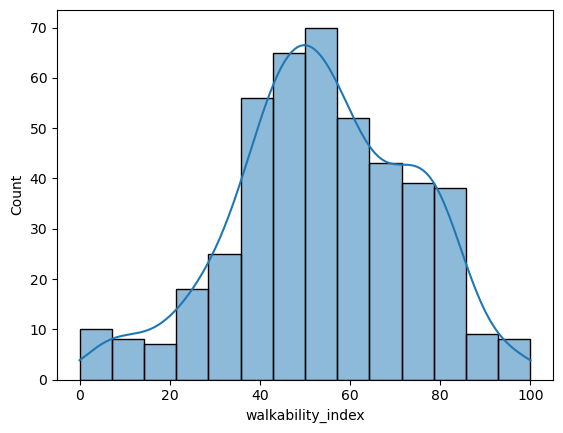

In [35]:
sns.histplot(gdf_rent["walkability_index"], kde=True)

<Axes: >

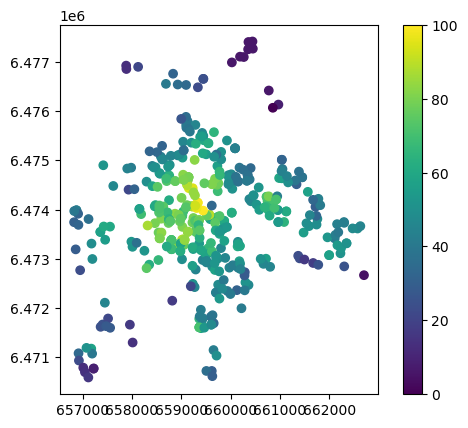

In [36]:
gdf_rent.plot(column="walkability_index", cmap="viridis", legend=True)

In [37]:
for cat, w in weights.items():
    gdf_rent[f"weighted_{cat}"] = gdf_rent.get(f"score_{cat}", 0) * w

In [38]:
gdf_rent[[c for c in gdf_rent.columns if c.startswith("weighted_")]].sum().sort_values(ascending=False) # shows total weighted score. shows what contributes how much to walkability score


weighted_food_grocery          26.867854
weighted_food_drink            23.675940
weighted_healthcare            19.758093
weighted_parks_green           18.942171
weighted_transport             17.744827
weighted_education             16.657984
weighted_play_recreation       12.377981
weighted_sports_facilities     11.580424
weighted_higher_education       7.603409
weighted_services_utilities     7.469931
weighted_community_social       6.492682
weighted_finance_admin          5.602381
weighted_sports_leisure         4.531083
weighted_health_beauty          3.649880
weighted_parking                3.433517
weighted_misc_services          3.337617
weighted_clothing               1.595394
weighted_vehicles               1.357648
weighted_home_furniture         1.338162
weighted_electronics            1.116261
weighted_other                  0.752656
dtype: float64

In [85]:
weighted_cols = [c for c in gdf_rent.columns if c.startswith("weighted_")]

In [86]:
gdf_rent['dominant_category'] = gdf_rent[weighted_cols].idxmax(axis=1)
gdf_rent['dominant_category'] = gdf_rent['dominant_category'].str.replace('weighted_', '')

In [87]:
categories = gdf_rent['dominant_category'].unique()


cmap = matplotlib.colormaps['tab10'].resampled(len(categories))

#mapping category to a color
color_dict = {cat: cmap(i) for i, cat in enumerate(categories)}

#  adding a color to each rental
gdf_rent['color'] = gdf_rent['dominant_category'].map(color_dict)

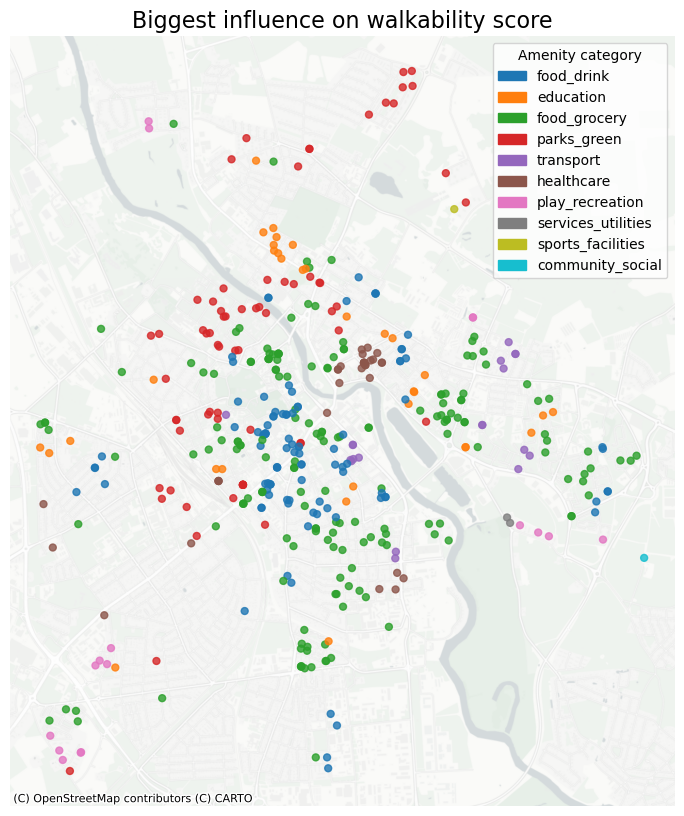

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot all rentals at once with assigned colors
gdf_rent.plot(
    ax=ax,
    color=gdf_rent['color'],
    markersize=25,
    alpha=0.8
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=gdf_rent.crs, zoom=14)

#legend
handles = [mpatches.Patch(color=color_dict[cat], label=cat) for cat in categories]
ax.legend(handles=handles, fontsize=10, title="servicecategory", markerscale=1)

ax.set_title("Biggest influence on walkability score", fontsize=16)
ax.axis('off')

plt.show()

In [89]:
avg_price_by_category = gdf_rent.groupby('dominant_category')['price'].mean().sort_values(ascending=False)
print(avg_price_by_category)

dominant_category
services_utilities    740.000000
sports_facilities     600.000000
play_recreation       566.176471
parks_green           534.764706
healthcare            519.937500
transport             503.631579
food_drink            485.040816
food_grocery          460.146893
education             445.272727
community_social      300.000000
Name: price, dtype: float64


In [ ]:
# Rentals where proximity to services/utilities drives walkability are the most expensive on average.

### Amenity diversity score

In [93]:
#gdf_rent.columns

In [40]:
radius = 800 # radius of search for services

In [41]:
# counting how many categories of service are within 800 m along the network
category_cols = [col for col in gdf_rent.columns if col.startswith("dist_")]

In [42]:
# Boolean
within_radius = gdf_rent[category_cols] <= radius

In [43]:
# counting number of categories within radius
gdf_rent["amenity_diversity_net"] = within_radius.sum(axis=1)

In [44]:
# normalization
gdf_rent["amenity_diversity_net_norm"] = gdf_rent["amenity_diversity_net"] / 21

In [45]:
corrs = gdf_rent[["price", "amenity_diversity_net_norm"]].corr()
print(corrs)

                               price  amenity_diversity_net_norm
price                       1.000000                   -0.064213
amenity_diversity_net_norm -0.064213                    1.000000


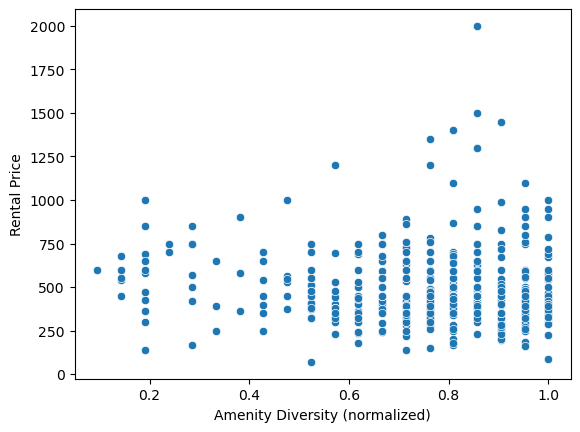

In [46]:
sns.scatterplot(data=gdf_rent, x="amenity_diversity_net_norm", y="price")
plt.xlabel("Amenity Diversity (normalized)")
plt.ylabel("Rental Price")
plt.show()

In [47]:
# Assuming gdf_rent has 'price' and 'area_m2'
gdf_rent["price_per_m2"] = gdf_rent["price"] / gdf_rent["area_sqm"]

# Compute correlations with per m² price
cols_to_check = ["amenity_diversity_net_norm"]
corrs_per_m2 = gdf_rent[["price_per_m2"] + cols_to_check].corr()
print(corrs_per_m2)

                            price_per_m2  amenity_diversity_net_norm
price_per_m2                    1.000000                    0.128927
amenity_diversity_net_norm      0.128927                    1.000000


### Plots for data visualization

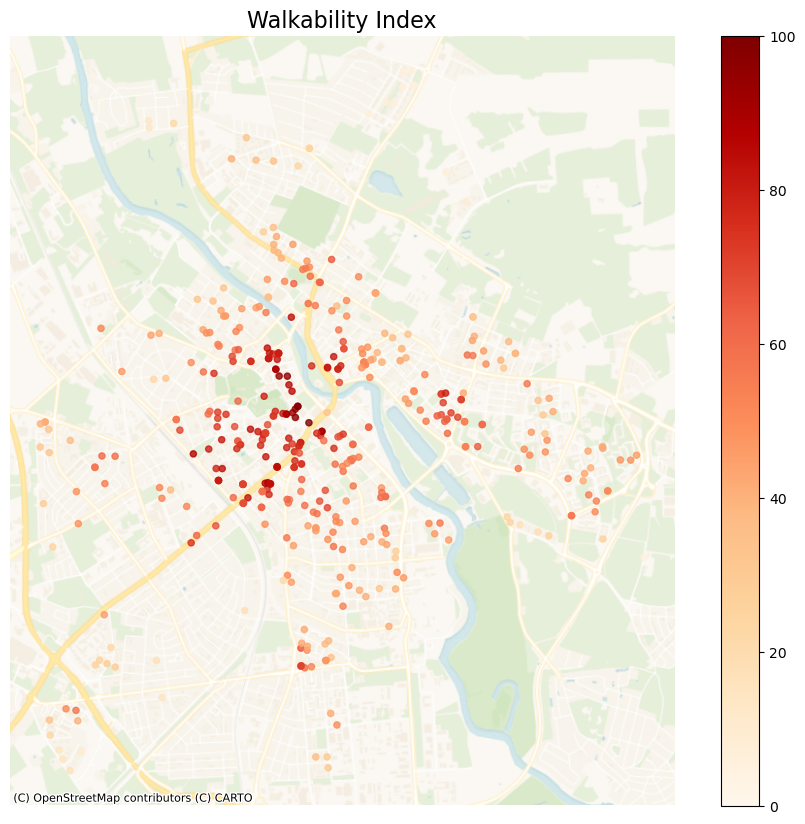

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="walkability_index",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)
#gdf_place_web.boundary.plot(ax=ax, edgecolor="black", linewidth=2)


ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Walkability Index", fontsize=16)
ax.axis('off')
plt.show()

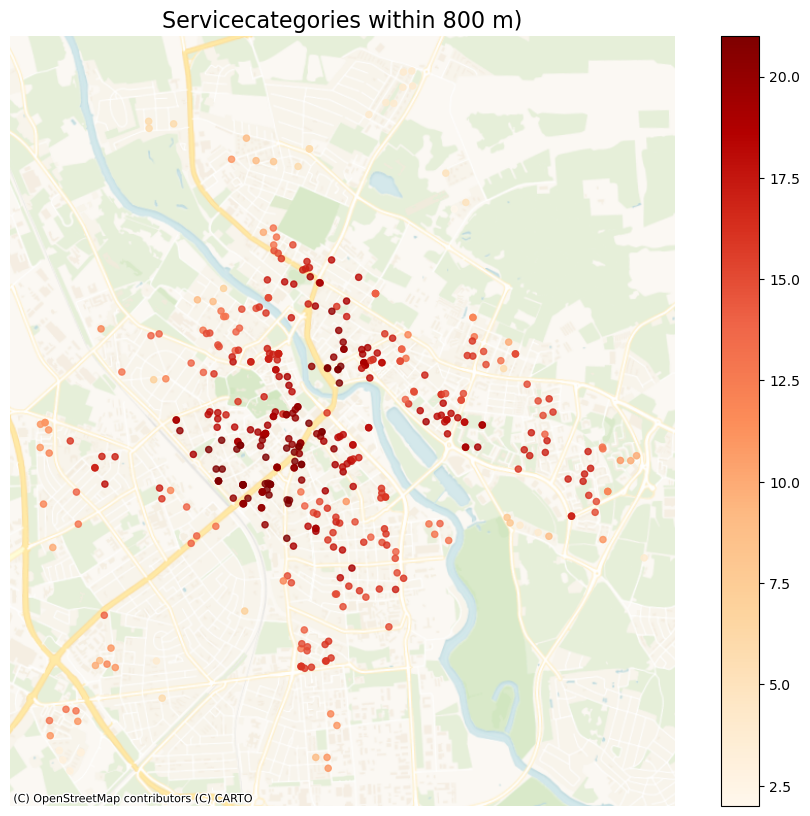

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_rent.plot(
    column="amenity_diversity_net",
    cmap="OrRd",
    legend=True,
    markersize=20,
    alpha=0.8,
    ax=ax
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs=gdf_rent.crs)

ax.set_title("Servicecategories within 800 m)", fontsize=16)
ax.axis('off')
plt.show()
